<a href="https://colab.research.google.com/github/Yukiii0517/QM2/blob/main/QM_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Method Overview
**Objective**: This study examines the relationship between gambling expenditure and labour market conditions in Australia, focusing on unemployment rates across eight regions and at the national level. The analysis proceeds in two stages:

**Panel regression** to identify robust **correlations** while controlling for unobserved regional heterogeneity.

**Granger causality analysis** to examine lead–lag dynamics and temporal **causation**.

This two-step approach allows the study to separate contemporaneous association from dynamic predictive causality.

# 1. Data
**1.1 Unit of Analysis**

Cross-sectional unit: Australian regions i=1,…,8

Time unit: Annual observations t=1,…,T

Balanced panel : Each region observed over the same time span

**1.2 Key Variables**

*  Dependent or independent depends on the test direction
*   Gambling_it: Real per-capita gambling expenditure ($)
*   Unemp_it: Regional unemployment rate (%)

**1.3 Transformations**

Gambling → ln(Gambling_it)

**1.4 Control variables (X_it):**

Wage price index

Disposable income

Population

Time dummies to absorb national shocks



In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
!pip install linearmodels
from linearmodels.panel import PanelOLS

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 11.5 MB/s eta 0:00:00


In [3]:
from google.colab import files
uploaded = files.upload()

Saving QM2.csv to QM2.csv


In [19]:
# Read data
df = pd.read_csv('QM2.csv')
df.head()

,State,Year,Real per capita total gambling expenditure value ($),Wage price index,Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $)
0,ACT,1998–99,1739.17,69.25,6.00,11739.0
1,ACT,1999–00,1757.75,70.98,5.04,12528.0
2,ACT,2000–01,1761.04,73.50,4.58,12807.0
3,ACT,2001–02,1718.74,75.80,4.52,13462.0
4,ACT,2002–03,1723.14,78.40,4.26,14253.0


In [21]:
# Convert year columns
df.dropna(subset=['Year'], inplace=True)
df['year'] = df['Year'].str[-2:].astype(int) + 2000
df.loc[df['year'] > 2025, 'year'] -= 100
df

,State,Year,Real per capita total gambling expenditure value ($),Wage price index,Unemployment rate (%),Final consumption expenditure minus net loss from gambling ( Millions $),year
0,ACT,1998–99,1739.17,69.25,6.00,11739.0,1999
1,ACT,1999–00,1757.75,70.98,5.04,12528.0,2000
2,ACT,2000–01,1761.04,73.50,4.58,12807.0,2001
3,ACT,2001–02,1718.74,75.80,4.52,13462.0,2002
4,ACT,2002–03,1723.14,78.40,4.26,14253.0,2003
...,...,...,...,...,...,...,...
203,WA,2019–20,787.04,132.48,6.02,126209.0,2020
204,WA,2020–21,971.28,134.43,6.09,129351.0,2021
205,WA,2021–22,946.83,137.35,3.81,137505.0,2022
206,WA,2022–23,925.11,142.58,3.56,144880.0,2023


In [22]:
# Relabel the columns
STATE = "State"
YEAR  = "year"
GAMB  = "Real per capita total gambling expenditure value ($)"
UNEMP = "Unemployment rate (%)"
WPI   = "Wage price index"

# Keep only necessary columns
df = df[[STATE, YEAR, GAMB, UNEMP, WPI]].copy()

# Ensure numeric data of all variables
df[[GAMB, UNEMP, WPI]] = df[[GAMB, UNEMP, WPI]].apply(pd.to_numeric, errors="coerce")

# Log gambling
df = df[df[GAMB] > 0]
df["log_gambling"] = np.log(df[GAMB])

# Drop missing and set panel index
df = df.dropna(subset=[STATE, YEAR, "log_gambling", UNEMP, WPI])
df = df.set_index([STATE, YEAR]).sort_index()
df

Real per capita total gambling expenditure value ($)  \
State year                                                         
ACT   1999                                            1739.17      
      2000                                            1757.75      
      2001                                            1761.04      
      2002                                            1718.74      
      2003                                            1723.14      
...                                                       ...      
WA    2020                                             787.04      
      2021                                             971.28      
      2022                                             946.83      
      2023                                             925.11      
      2024                                             896.41      

            Unemployment rate (%)  Wage price index  log_gambling  
State year                                                         
ACT   1999                   6.00             69.25      7.461163  
      2000                   5.04             70.98      7.471790  
      2001                   4.58             73.50      7.473660  
      2002                   4.52             75.80      7.449347  
      2003                   4.26             78.40      7.451903  
...                           ...               ...           ...  
WA    2020                   6.02            132.48      6.668279  
      2021                   6.09            134.43      6.878615  
      2022                   3.81            137.35      6.853120  
      2023                   3.56            142.58      6.829913  
      2024                   3.73            148.85      6.798398  

[208 rows x 4 columns]

# 3. Models
# 3.1 Time-series OLS + Panel Regression
**3.1.A Model A: Gambling leads unemployment**

*   Test of gambling → later unemployment




**Model A1: National time-series OLS (Australia as a whole)**

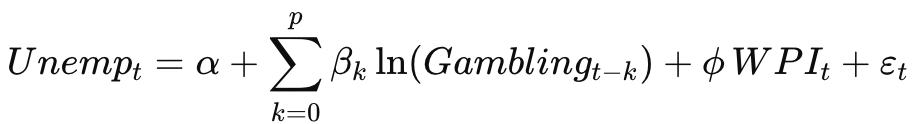

**Model A2: Single-region time-series OLS** (e.g. NSW only)

* Same equation - just applied to one region.

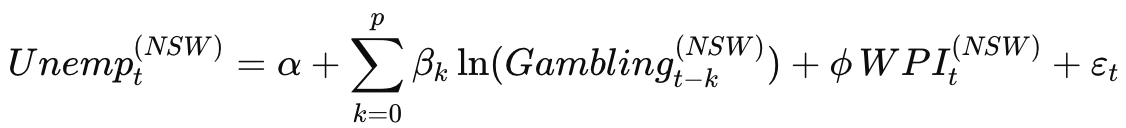

Both two times series OLS test for “Does gambling lead unemployment within this specific region over time?”

In [36]:
# 1) TIME-SERIES OLS (works for NATIONAL and any SINGLE region)

def ts_ols_modelA(ts_df, *, year_col=YEAR, p=1):
    """
    Input: one time series (one row per year), with columns:
      year_col, UNEMP, 'log_gambling', WPI
    Returns: (results, data_used)
    """
    d = ts_df[[year_col, UNEMP, "log_gambling", WPI]].dropna().sort_values(year_col).copy()

    for k in range(0, p + 1):
        d[f"g_L{k}"] = d["log_gambling"].shift(k)

    rhs = [f"g_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


In [37]:
# How to call them

# ---- NATIONAL time-series ----
# Make a national series by aggregating across states each year
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", WPI]].mean().reset_index()
res_nat, used_nat = ts_ols_modelA(nat, year_col=YEAR, p=1) # change p here for different lags
print(res_nat.summary())

# ---- SINGLE region time-series (e.g., NSW) ----
nsw = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", WPI]] # change "NSW here for different region
res_nsw, used_nsw = ts_ols_modelA(nsw, year_col=YEAR, p=1) # change p here for different lags
print(res_nsw.summary())


                              OLS Regression Results                             
Dep. Variable:     Unemployment rate (%)   R-squared:                       0.338
Model:                               OLS   Adj. R-squared:                  0.244
Method:                    Least Squares   F-statistic:                     3.704
Date:                   Sun, 28 Dec 2025   Prob (F-statistic):             0.0278
Time:                           14:18:59   Log-Likelihood:                -25.166
No. Observations:                     25   AIC:                             58.33
Df Residuals:                         21   BIC:                             63.21
Df Model:                              3                                         
Covariance Type:                     HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const     

**Model A3: 8-region panel** (main regional analysis)

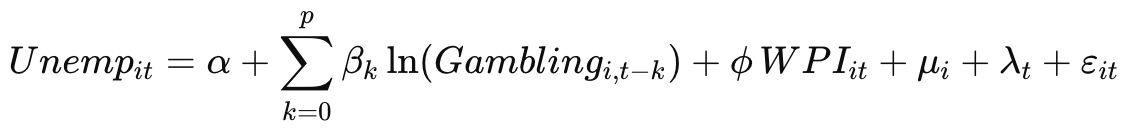

**Note:** We only use panel regression when we have both **cross-sectional** and **time-series** data. In this case, it only works when we include all 8 regions together with their time-series data.

In the previous section, I use time-series OLS because we do not use the cross-sectional dimension and instead examine one region at a time.


Panel model tells “Within regions, does gambling lead unemployment **after accounting for regional differences and national shocks?**”

**The error terms**

**1. μ_i:** Region fixed effects = everything about that region that does NOT change over time

“Controls for things that make NSW permanently different from WA.”

Examples: Cultural attitudes toward gambling, Long-run industry structure (e.g. mining-heavy WA), Historical labour-market characteristics, etc

These factors differ across regions but are constant over time within each region.

**2. λ_t:** Year fixed effects = everything that affects all regions in year

“Controls for things that affect all regions in a given year, like COVID.”

Examples: National recessions / booms, COVID, Interest-rate cycles, etc.

So if unemployment and gambling both spike in 2020: that variation is absorbed by 𝜆 not attributed to gambling causing unemployment

**3.ε_it:** Idiosyncratic shocks = unexpected region–year noise

“Everything else we can’t explain.”

Examples: A local factory closure, A temporary regional event, Measurement error, etc.

In [38]:
# 2) PANEL FE
def panel_fe_modelA(df_panel, *, p=1, states=None):

    # ensure MultiIndex
    d = df_panel.copy()
    if not isinstance(d.index, pd.MultiIndex):
        d = d.set_index([STATE, YEAR]).sort_index()

    # optional subset of states (>=2)
    if states is not None:
        if isinstance(states, str):
            states = [states]
        d = d.loc[d.index.get_level_values(0).isin(states)].copy()

    # lags within state: k=0..p
    for k in range(0, p + 1):
        d[f"g_L{k}"] = d.groupby(level=0)["log_gambling"].shift(k)

    rhs = [f"g_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=[UNEMP] + rhs)

    y = d[UNEMP]
    X = d[rhs]

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    res = mod.fit(cov_type="clustered", cluster_entity=True)
    return res

In [59]:
# How to call it
# ---- 8-region PANEL FE ----
res_panel = panel_fe_modelA(df, p=3) # change p here for different lags
print(res_panel.summary)

                            PanelOLS Estimation Summary                            
Dep. Variable:     Unemployment rate (%)   R-squared:                        0.1835
Estimator:                      PanelOLS   R-squared (Between):             -16.649
No. Observations:                    184   R-squared (Within):              -7.6584
Date:                   Sun, Dec 28 2025   R-squared (Overall):             -16.368
Time:                           15:22:23   Log-likelihood                   -131.11
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      6.6986
Entities:                              8   P-value                           0.0000
Avg Obs:                          23.000   Distribution:                   F(5,149)
Min Obs:                          23.000                                           
Max Obs:                          23.000   F-statistic (robust):            

**3.1.B Model B: Gambling lags unemployment**

Test of unemployment → later gambling




This part should be really easy to understand if you understand 3.1.A, we are just switching the dependent and independent variables.
Therefore, I'll simplify the explanation ;)



**Model B1 and B2: Time-series OLS run at National and Regional level**

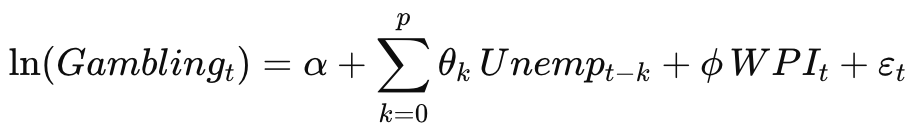

In [49]:
def ts_ols_modelB(ts_df, *, year_col, p=1):
    # Same cleaning pattern as Model A
    d = ts_df[[year_col, UNEMP, "log_gambling", WPI]].dropna().sort_values(year_col).copy()

    # Only change vs Model A: lag unemployment instead of gambling
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    # Only change vs Model A: y is log_gambling
    y = d["log_gambling"].astype(float)
    X = sm.add_constant(d[rhs].astype(float))

    res = sm.OLS(y, X).fit(cov_type="HAC", cov_kwds={"maxlags": p})
    return res, d


In [55]:
# NATIONAL
df_flat = df.reset_index()
nat = df_flat.groupby(YEAR)[[UNEMP, "log_gambling", WPI]].mean().reset_index()

res_nat_B, used_nat_B = ts_ols_modelB(nat, year_col=YEAR, p=2)# change p here
print(res_nat_B.summary())

# Regional
nsw = df_flat[df_flat["State"] == "NSW"][[YEAR, UNEMP, "log_gambling", WPI]] # change region here

res_nsw_B, used_nsw_B = ts_ols_modelB(nsw, year_col=YEAR, p=2)# change p here
print(res_nsw_B.summary())



                            OLS Regression Results                            
Dep. Variable:           log_gambling   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     11.41
Date:                Sun, 28 Dec 2025   Prob (F-statistic):           6.86e-05
Time:                        15:15:19   Log-Likelihood:                 29.312
No. Observations:                  24   AIC:                            -48.62
Df Residuals:                      19   BIC:                            -42.73
Df Model:                           4                                         
Covariance Type:                  HAC                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                8.0405      0.187  

**Model B3: 8-region panel**

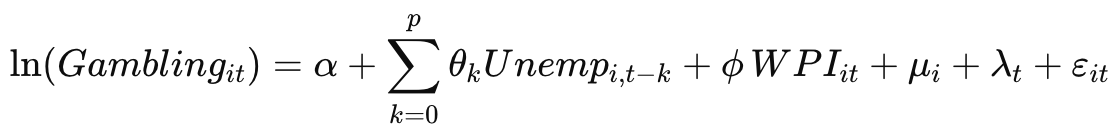

In [56]:
def panel_modelB(df_panel, *, p=1):

    d = df_panel.copy()

    # Lags of unemployment: k = 0..p
    for k in range(0, p + 1):
        d[f"u_L{k}"] = d.groupby(level=0)[UNEMP].shift(k)

    rhs = [f"u_L{k}" for k in range(0, p + 1)] + [WPI]
    d = d.dropna(subset=["log_gambling"] + rhs)

    y = d["log_gambling"]
    X = d[rhs]

    mod = PanelOLS(y, X, entity_effects=True, time_effects=True)
    return mod.fit(cov_type="clustered", cluster_entity=True)

In [58]:
# call panel
resB_panel = panel_modelB(df, p=3)
print(resB_panel.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:           log_gambling   R-squared:                        0.1378
Estimator:                   PanelOLS   R-squared (Between):             -0.4291
No. Observations:                 184   R-squared (Within):               0.0414
Date:                Sun, Dec 28 2025   R-squared (Overall):             -0.4284
Time:                        15:22:02   Log-likelihood                    10.748
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      4.7632
Entities:                           8   P-value                           0.0005
Avg Obs:                       23.000   Distribution:                   F(5,149)
Min Obs:                       23.000                                           
Max Obs:                       23.000   F-statistic (robust):             14.446
                            

# 3.2 Granger causality analysis

3.2. Model A2: Gambling Granger-causes unemployment
* supports gambling leads unemp

3.2.b Model B2: Unemployment Granger-causes gambling
* supports gambling lags unemp